In [ ]:
# 📘 FX Reinforcement Learning System（簡易版）
"""
- 作成者：fxinsightslab
- バージョン：v1.0
- 公開日：2025年4月xx日
- ライセンス：個人利用限定（再配布・商用利用・改変配布禁止）

---

## 📄 利用に関する注意事項

- このノートブックは学習・研究・検証目的で提供されています。
- 実際の売買判断やトレード運用は自己責任の下で行ってください。
- 本テンプレートを改変しての再配布、または第三者への提供・販売は禁止です。

> 💬 ご質問や不具合の報告は、X（旧Twitter）[@fxinsightslab](https://x.com/fxinsightslab) までお気軽にどうぞ！

---

✅ 以下のセルから順次実行すると最後の評価まで行えるようになっています。
"""

In [1]:
# データ準備
################################################################
# 指定されたプロジェクトルートからノートブックを実行し、
# MT5からGOLDのM5データを取得・前処理して表示する
################################################################
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import talib
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from sklearn.preprocessing import StandardScaler
import os


# --- プロジェクトルートを自動検出する関数 ---
def find_project_root(target_folder_name="FX Reinforcement Learning System（簡易版）"):
    current_path = os.getcwd() # 現在の作業ディレクトリを取得
    while True:
        # 現在のフォルダ名がターゲット名と一致するか確認
        if os.path.basename(current_path) == target_folder_name:
            return current_path # 一致すればそのパスを返す
        parent = os.path.dirname(current_path)# 一つ上の階層へ移動
        if parent == current_path:
            # ルートまで探索しても見つからなければエラーを投げる
            raise FileNotFoundError(f"{target_folder_name} フォルダが上位ディレクトリに見つかりませんでした。")
        current_path = parent# 次のループでは上位フォルダを探索

try:# プロジェクトルートのパスを取得し、指定ノートブックを実行
    base_path = find_project_root()  
    target_path = os.path.join(base_path, "src/utils/data_preparation.ipynb").replace("\\", "/")
    %run "$target_path"# ノートブックを実行して関数などを読み込み
except FileNotFoundError as e:
    print(e)# 見つからなければエラーメッセージを表示


# --- MT5からデータ取得 ---
mt5.initialize()  # MT5との接続を初期化
symbol = "GOLD"  # 取得する銘柄を指定
# GOLDの5分足データを「現在の最新の足」から遡って1000本取得
rates = mt5.copy_rates_from_pos(symbol, mt5.TIMEFRAME_M5, 1000, 100000)  # 0 は「現在時刻に最も近いバー（=最新バー）を起点」という意味
mt5.shutdown()  # MT5との接続を終了

# --- データフレームに変換・整形 ---
df = pd.DataFrame(rates)  # MT5データをDataFrame形式に変換
df["time"] = pd.to_datetime(df["time"], unit="s")  # UNIX時間を日時形式に変換

# --- 前処理実行（data_preparation.ipynbで定義された関数） ---
df = prepare_data(df)  # 指定関数でテクニカル指標などを追加・整形

# --- 結果表示（先頭5行） ---
print(df.head())  # データの先頭を表示して確認

                  time      open      high       low     close  tick_volume  \
49 2023-12-04 18:55:00 -1.421778 -1.412316 -1.424131 -1.412044          911   
50 2023-12-04 19:00:00 -1.412063 -1.409119 -1.410501 -1.411897          755   
51 2023-12-04 19:05:00 -1.412063 -1.405687 -1.410824 -1.404207          669   
52 2023-12-04 19:10:00 -1.404167 -1.401494 -1.404420 -1.400039          755   
53 2023-12-04 19:15:00 -1.400792 -1.399499 -1.399897 -1.400450          858   

    spread  real_volume    volume  raw_close    SMA_20    EMA_50    RSI_14  \
49      26            0  0.743580    2025.83 -1.411848 -1.358400 -1.056780   
50      28            0  0.362891    2025.88 -1.413487 -1.360495 -1.047210   
51      32            0  0.153025    2028.50 -1.414165 -1.362206 -0.558481   
52      28            0  0.362891    2029.92 -1.413556 -1.363686 -0.313211   
53      26            0  0.614243    2029.78 -1.412797 -1.365124 -0.335449   

        MACD    ATR_14  BB_upper  BB_lower       OBV  zi

In [2]:
import numpy as np
from stable_baselines3 import PPO
import torch
import torch.nn.functional as F

# ========== サブAI（トレンドAI・ボラティリティAI）をラップするユーティリティクラス ==========
################################################################
# obs 受け取り	強化学習環境からの状態を受け取る
# .predict()	PPOモデルでアクションを推論
# softmax(logits)	推論アクションの信頼度スコアを取得
# 出力形式	AIタイプに応じてラベル付きの辞書で返す（trend_ or volatility_）
################################################################
class SubAIWrapper:
    def __init__(self, model, ai_type="trend"):
        self.model = model  # 強化学習モデル（PPO）
        self.ai_type = ai_type  # "trend" or "volatility"

    def predict(self, obs):
        obs_reshaped = obs.reshape(1, -1)
        action, _ = self.model.predict(obs_reshaped, deterministic=True)

        with torch.no_grad():
            device = next(self.model.parameters()).device  # ✅ デバイス取得
            obs_tensor = torch.tensor(obs_reshaped, dtype=torch.float32, device=device)
            logits = self.model.policy.mlp_extractor.forward_actor(obs_tensor)
            probs = F.softmax(logits, dim=1).cpu().numpy()[0]
            confidence_or_score = float(probs[action])

        if self.ai_type == "trend":
            action_label = ["Hold", "Buy", "Sell"][action]
            return {
                "trend_action": action_label,
                "trend_confidence": confidence_or_score
            }

        elif self.ai_type == "volatility":
            action_label = ["Hold", "Avoid", "Entry"][action]
            return {
                "volatility_action": action_label,
                "volatility_score": confidence_or_score
            }

    def parameters(self):
        return self.model.parameters()

    def get_device(self):
        return next(self.model.parameters()).device


In [3]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import torch
import torch.nn.functional as F

# ========== マネージャーAI用の統合環境 ==========
##################################################
# 状態空間（21次元）	トレンドAI＋ボラティリティAI の出力 + 信頼度 + テクニカル指標
# 行動空間（4種類）	0=保留、1=買い、2=売り、3=決済（exit）
# 報酬関数	価格差＋含み益＋コスト＋不正行動ペナルティ
# run_backtest()	シグナル記録機能付きの簡易シミュレーション
##################################################
class RealDataManagerEnv(gym.Env):
    def __init__(self, df, trend_model, vol_model):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.trend_model = trend_model  # SubAIWrapper(trend_model)
        self.vol_model = vol_model      # SubAIWrapper(vol_model)
        self.current_step = 0
        self.max_steps = len(df) - 1

        # 状態空間（21次元）：trend(3) + vol(3) + confidence(2) + 技術指標(13)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(21,), dtype=np.float32)

        # 行動空間：0=Hold, 1=Long, 2=Short, 3=Close
        self.action_space = spaces.Discrete(4)

        self.position = None          # 現在のポジション状態（"long", "short", None）
        self.entry_price = None       # エントリー価格

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.position = None
        self.entry_price = None
        return self._get_obs(), {}

    # --- 状態ベクトルの構築（SubAI + テクニカル指標）---
    def _get_obs(self):
        row = self.df.iloc[self.current_step]
        obs_vector = np.array([
            row["close"], row["SMA_20"], row["RSI_14"], row["MACD"], row["ATR_14"],
            row["BB_upper"], row["BB_lower"], row.get("volume", 0.0),
            row["open"], row["high"], row["low"], row["EMA_50"],
            row["OBV"]
        ], dtype=np.float32)

        # SubAIのアクション＆信頼度を取得（ワンホット + 信頼度スコア）
        trend_action, _ = self.trend_model.model.predict(obs_vector.reshape(1, -1), deterministic=True)
        vol_action, _ = self.vol_model.model.predict(obs_vector.reshape(1, -1), deterministic=True)

        trend_confidence = [self._get_confidence(self.trend_model, obs_vector)]
        vol_score = [self._get_confidence(self.vol_model, obs_vector)]

        trend_onehot = np.eye(3)[int(trend_action)]
        vol_onehot = np.eye(3)[int(vol_action)]

        # 統合された状態ベクトルを返す
        return np.concatenate([trend_onehot, vol_onehot, trend_confidence, vol_score, obs_vector], dtype=np.float32)

    # --- 環境1ステップの処理 ---
    def step(self, action):
        reward = self._calc_reward(action)
        self.current_step += 1
        terminated = self.current_step >= self.max_steps
        truncated = False
        return self._get_obs(), reward, terminated, truncated, {"position": self.position}

    # --- 報酬関数（価格差とポジション状況に基づく）---
    def _calc_reward(self, action):
        price_now = self.df["close"].iloc[self.current_step]
        TRADING_COST = 0.05
        reward = 0.0

        # 保留中：保有ポジションの含み益/損を反映
        if action == 0:  # Hold
            if self.position is not None and self.entry_price is not None:
                unrealized = price_now - self.entry_price if self.position == "long" else self.entry_price - price_now
                reward += unrealized * 0.1  # 含み益評価
            else:
                reward = -0.001  # 何もしないペナルティ

        elif action == 1:  # Long
            reward -= TRADING_COST
            if self.position is None:
                self.position = "long"
                self.entry_price = price_now
            elif self.position == "short":
                pnl = self.entry_price - price_now
                reward += pnl
                self.position = "long"
                self.entry_price = price_now

        elif action == 2:  # Short
            reward -= TRADING_COST
            if self.position is None:
                self.position = "short"
                self.entry_price = price_now
            elif self.position == "long":
                pnl = price_now - self.entry_price
                reward += pnl
                self.position = "short"
                self.entry_price = price_now

        elif action == 3:  # Close
            if self.position is not None:
                if self.position == "long":
                    reward += price_now - self.entry_price
                elif self.position == "short":
                    reward += self.entry_price - price_now
                self.position = None
                self.entry_price = None
            else:
                reward = -1  # ポジションがないのにClose → ペナルティ

        return reward

    # --- SubAIのSoftmax信頼度を計算 ---
    def _get_confidence(self, model, obs_vector):
        # SubAIWrapper 経由で PPO モデルが格納されている前提
        ppo_model = model.model if hasattr(model, 'model') else model
    
        device = next(ppo_model.policy.parameters()).device  # ✅ 修正箇所
        obs_tensor = torch.tensor(obs_vector, dtype=torch.float32, device=device).unsqueeze(0)
    
        with torch.no_grad():
            logits = ppo_model.policy.mlp_extractor.forward_actor(obs_tensor)
            probs = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()[0]
    
        return float(np.max(probs))


    # --- バックテストモード：AIの行動ログを記録 ---
    def run_backtest(self, model, max_steps=1000):
        obs, _ = self.reset()
        self.signals = []

        for _ in range(max_steps):
            action, _ = model.predict(obs, deterministic=True)
            action = int(action)

            if action in [1, 2]:  # ロング or ショート
                pos_type = "long" if action == 1 else "short"

                if self.position is None:
                    self.signals.append((self.current_step, "entry", pos_type))

                elif self.position != pos_type:
                    self.signals.append((self.current_step, "exit", self.position))
                    self.signals.append((self.current_step, "entry", pos_type))

            elif action == 3 and self.position is not None:
                self.signals.append((self.current_step, "exit", self.position))

            obs, reward, terminated, truncated, _ = self.step(action)

            if terminated or truncated:
                break

        # 最後にポジションが残っていた場合、明示的に終了処理
        if self.position is not None:
            self.signals.append((self.current_step, "exit", self.position))

        return self.signals


In [4]:
import os
from stable_baselines3 import PPO
import zipfile
import glob
# --- モデルの読み込み処理 ---
try:
    base_path = find_project_root()
    models_dir = os.path.join(base_path, "src/agents/models")
    model_prefix = "trend_ai_ppo"

    # --- モデルファイル群の中から最新ファイルを検索 ---
    pattern = os.path.join(models_dir, f"{model_prefix}_*.zip")
    model_files = glob.glob(pattern)

    if not model_files:
        print(f"❌ モデルファイルが見つかりません: {pattern}")
    else:
        # --- 最新ファイルを選択 ---
        latest_model_path = max(model_files, key=os.path.getctime)
        print("✅ 最新モデルファイル:", latest_model_path)

        try:
            # --- モデル読み込み ---
            model = PPO.load(latest_model_path)
            print("✅ モデルの読み込みに成功しました！")

            # --- zipファイルの内容確認 ---
            with zipfile.ZipFile(latest_model_path, 'r') as zip_ref:
                print("📦 含まれるファイル一覧:")
                for name in zip_ref.namelist():
                    print("  -", name)

        except Exception as e:
            print("❌ モデルの読み込みに失敗しました:", e)

except FileNotFoundError as e:
    print("❌ プロジェクトルートの検出に失敗しました:", e)
trend_model = model

# --- モデルの読み込み処理 ---
try:
    base_path = find_project_root()
    models_dir = os.path.join(base_path, "src/agents/models")
    model_prefix = "volatility_ai_ppo"

    # --- モデルファイル群の中から最新ファイルを検索 ---
    pattern = os.path.join(models_dir, f"{model_prefix}_*.zip")
    model_files = glob.glob(pattern)

    if not model_files:
        print(f"❌ モデルファイルが見つかりません: {pattern}")
    else:
        # --- 最新ファイルを選択 ---
        latest_model_path = max(model_files, key=os.path.getctime)
        print("✅ 最新モデルファイル:", latest_model_path)

        try:
            # --- モデル読み込み ---
            model = PPO.load(latest_model_path)
            print("✅ モデルの読み込みに成功しました！")

            # --- zipファイルの内容確認 ---
            with zipfile.ZipFile(latest_model_path, 'r') as zip_ref:
                print("📦 含まれるファイル一覧:")
                for name in zip_ref.namelist():
                    print("  -", name)

        except Exception as e:
            print("❌ モデルの読み込みに失敗しました:", e)

except FileNotFoundError as e:
    print("❌ プロジェクトルートの検出に失敗しました:", e)

    
# モデル読み込み
vol_model = model

# --- モデルの読み込み処理 ---
try:
    base_path = find_project_root()
    models_dir = os.path.join(base_path, "src/manager/models")
    model_prefix = "manager_ai_ppo"

    # --- モデルファイル群の中から最新ファイルを検索 ---
    pattern = os.path.join(models_dir, f"{model_prefix}_*.zip")
    model_files = glob.glob(pattern)

    if not model_files:
        print(f"❌ モデルファイルが見つかりません: {pattern}")
    else:
        # --- 最新ファイルを選択 ---
        latest_model_path = max(model_files, key=os.path.getctime)
        print("✅ 最新モデルファイル:", latest_model_path)

        try:
            # --- モデル読み込み ---
            model = PPO.load(latest_model_path)
            print("✅ モデルの読み込みに成功しました！")

            # --- zipファイルの内容確認 ---
            with zipfile.ZipFile(latest_model_path, 'r') as zip_ref:
                print("📦 含まれるファイル一覧:")
                for name in zip_ref.namelist():
                    print("  -", name)

        except Exception as e:
            print("❌ モデルの読み込みに失敗しました:", e)

except FileNotFoundError as e:
    print("❌ プロジェクトルートの検出に失敗しました:", e)

# モデル読み込み
manager_model = model

✅ 最新モデルファイル: C:\Users\kotak\FX Reinforcement Learning System（簡易版）\src/agents/models\trend_ai_ppo_20250509_183126.zip
✅ モデルの読み込みに成功しました！
📦 含まれるファイル一覧:
  - data
  - pytorch_variables.pth
  - policy.pth
  - policy.optimizer.pth
  - _stable_baselines3_version
  - system_info.txt
✅ 最新モデルファイル: C:\Users\kotak\FX Reinforcement Learning System（簡易版）\src/agents/models\volatility_ai_ppo_20250509_200941.zip
✅ モデルの読み込みに成功しました！
📦 含まれるファイル一覧:
  - data
  - pytorch_variables.pth
  - policy.pth
  - policy.optimizer.pth
  - _stable_baselines3_version
  - system_info.txt
✅ 最新モデルファイル: C:\Users\kotak\FX Reinforcement Learning System（簡易版）\src/manager/models\manager_ai_ppo_20250509_125726.zip
✅ モデルの読み込みに成功しました！
📦 含まれるファイル一覧:
  - data
  - pytorch_variables.pth
  - policy.pth
  - policy.optimizer.pth
  - _stable_baselines3_version
  - system_info.txt


C:\Users\kotak\anaconda3\envs\fx_gpu\lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [17]:
import os
import glob
import datetime
import torch
import random
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import BaseCallback

print("torch.cuda.is_available():", torch.cuda.is_available())
print("torch.cuda.device_count():", torch.cuda.device_count())

# ✅ ランダム抽出関数
def get_random_slice(df, length=100):
    if len(df) <= length:
        return df.copy()
    start_idx = random.randint(0, len(df) - length)
    return df.iloc[start_idx:start_idx + length].reset_index(drop=True)


# ✅ モデル保存を日付付きで行う関数
def save_model_with_timestamp(model, model_name):
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    path = f"models/{model_name}_{timestamp}.zip"
    model.save(path)
    print(f"💾 モデル保存: {path}")


# ✅ 最新モデルを自動読み込み
def load_latest_model(model_prefix="manager_ai_ppo", models_dir="models"):
    files = glob.glob(os.path.join(models_dir, f"{model_prefix}_*.zip"))
    if not files:
        raise FileNotFoundError(f"'{model_prefix}_*.zip' に一致するモデルが見つかりません")
    latest_file = max(files, key=os.path.getctime)
    print(f"📥 最新モデル読み込み中: {latest_file}")
    model = PPO.load(latest_file, device="cpu")
    return model

# ✅ 学習率スケジューラ（減衰しつつ最低値を保証）
def lr_schedule(progress_remaining):
    min_lr = 1e-5
    max_lr = 3e-4
    factor = progress_remaining ** 2
    return min_lr + (max_lr - min_lr) * factor

# ✅ エントロピー監視による early stop + 自動再学習
class EntropyStopCallback(BaseCallback):
    def __init__(self, df, env_constructor, model_name, entropy_threshold=0.20, max_retries=30, verbose=1):
        super().__init__(verbose)
        self.df = df
        self.env_constructor = env_constructor
        self.model_name = model_name
        self.entropy_threshold = entropy_threshold
        self.retry_count = 0
        self.max_retries = max_retries

    def _on_step(self) -> bool:
        entropy = self.logger.name_to_value.get("train/entropy_loss")
        if entropy is not None and abs(entropy) < self.entropy_threshold:
            print(f"\n🛑 Entropy ({entropy:.4f}) < {self.entropy_threshold:.2f} → 学習停止")
            return False
        return True

    def _on_training_end(self) -> None:
        save_model_with_timestamp(self.model, self.model_name)
        if self.retry_count < self.max_retries:
            self.retry_count += 1
            print(f"🔁 再学習開始（{self.retry_count}回目）")
            new_df = get_random_slice(self.df)
            new_env = self.env_constructor(new_df)

            # ✅ モデルを再利用（重み保持）
            self.model.set_env(new_env)
            self.model.learn(total_timesteps=300000, callback=self)


# ✅ モデル読み込み or 新規作成
def load_or_create_model(env, model_name="manager_ai_ppo", force_new=False, verbose=1):
    if not force_new:
        try:
            model = load_latest_model(model_prefix=model_name)
            model.set_env(env)
            print(f"✅ モデル再利用完了")
            return model
        except FileNotFoundError:
            print("⚠ モデルが見つからないため、新規作成します。")

    print(f"🆕 モデル '{model_name}' を新規作成します。")
    return PPO(
        "MlpPolicy",
        env,
        verbose=verbose,
        learning_rate=lr_schedule,  # ← ここが追加
        policy_kwargs=dict(net_arch=[dict(pi=[256, 128], vf=[256, 128])]),
        device="cpu"
    )



# ✅ 環境構築関数（再学習用に渡す）
def create_env(df):
    sliced_df = get_random_slice(df, length=100)
    trend_wrapper = SubAIWrapper(trend_model, ai_type="trend")
    vol_wrapper   = SubAIWrapper(vol_model, ai_type="volatility")
    env = RealDataManagerEnv(sliced_df, trend_wrapper, vol_wrapper)
    return Monitor(env)


# --- 環境構築と学習フェーズ ---
env = create_env(df)
check_env(env)

model_name = "manager_ai_ppo"
force_train = True
model = load_or_create_model(env, model_name=model_name, force_new=force_train)
callback = EntropyStopCallback(df, create_env, model_name, entropy_threshold=0.0001)

try:
    print("🟢 Manager AI 学習開始（Ctrl+Cで手動中断できます）")
    model.learn(total_timesteps=300000, callback=callback)
except KeyboardInterrupt:
    print("\n🛑 手動停止 → モデル保存中...")
    save_model_with_timestamp(model, model_name)
else:
    save_model_with_timestamp(model, model_name)



torch.cuda.is_available(): True
torch.cuda.device_count(): 1
🆕 モデル 'manager_ai_ppo' を新規作成します。
Using cpu device
Wrapping the env in a DummyVecEnv.
🟢 Manager AI 学習開始（Ctrl+Cで手動中断できます）
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 99       |
|    ep_rew_mean     | -10.9    |
| time/              |          |
|    fps             | 245      |
|    iterations      | 1        |
|    time_elapsed    | 8        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 99          |
|    ep_rew_mean          | -9.36       |
| time/                   |             |
|    fps                  | 204         |
|    iterations           | 2           |
|    time_elapsed         | 20          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.022563096 |
|    clip_fractio

In [51]:
from collections import Counter

# ========== マネージャーAIの評価関数 ==========
##################################################
# Episode n: Total Reward	各エピソードでの累積報酬
# Actions = [...]	ステップごとの行動履歴（例: [0, 1, 0, 0, 3, ...]）
# 平均報酬	全エピソードの平均パフォーマンス指標
# 行動の出現頻度	どのアクションを何回取ったか（戦略傾向の分析に有効）
##################################################
def evaluate_manager_model(model, env, n_episodes=10):
    total_rewards = []         # 各エピソードの合計報酬を記録
    action_counter = Counter() # 全体の行動回数を集計

    for ep in range(n_episodes):
        obs, _ = env.reset()   # 環境を初期化
        done = False
        ep_reward = 0
        ep_actions = []

        while not done:
            action, _ = model.predict(obs, deterministic=True)
            action = int(action)  # NumPy型をPythonのintに変換（互換性のため）
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            ep_reward += reward
            ep_actions.append(action)

        total_rewards.append(ep_reward)
        action_counter.update(ep_actions)

        # --- 各エピソードの詳細表示 ---
        print(f"📊 Episode {ep + 1}: Total Reward = {ep_reward:.2f} | Actions = {ep_actions}")

    # --- 評価結果の集計・表示 ---
    avg_reward = sum(total_rewards) / len(total_rewards)
    print("\n✅ 評価完了！")
    print(f"🎯 平均報酬: {avg_reward:.2f}")
    print(f"🧠 行動の出現頻度: {dict(action_counter)}")

# ========================
# ✅ 評価用セットアップ
# ========================

# --- モデル読み込み（必要ならコメント解除）---
# trend_model = PPO.load("trend_ai_ppo")
# vol_model   = PPO.load("volatility_ai_ppo")

# --- Softmax信頼度付きのラッパーを作成 ---
trend_wrapper = SubAIWrapper(trend_model, ai_type="trend")
vol_wrapper   = SubAIWrapper(vol_model, ai_type="volatility")

# --- 統合環境の構築（リアルデータで評価）---
env = RealDataManagerEnv(df, trend_wrapper, vol_wrapper)

# --- Manager AI の評価実行（1エピソードだけ試す場合）---
# manager_model = PPO.load("manager_ai_ppo")  # モデル読み込み（必要に応じて）
evaluate_manager_model(manager_model, env, n_episodes=1)


📊 Episode 1: Total Reward = -18.24 | Actions = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

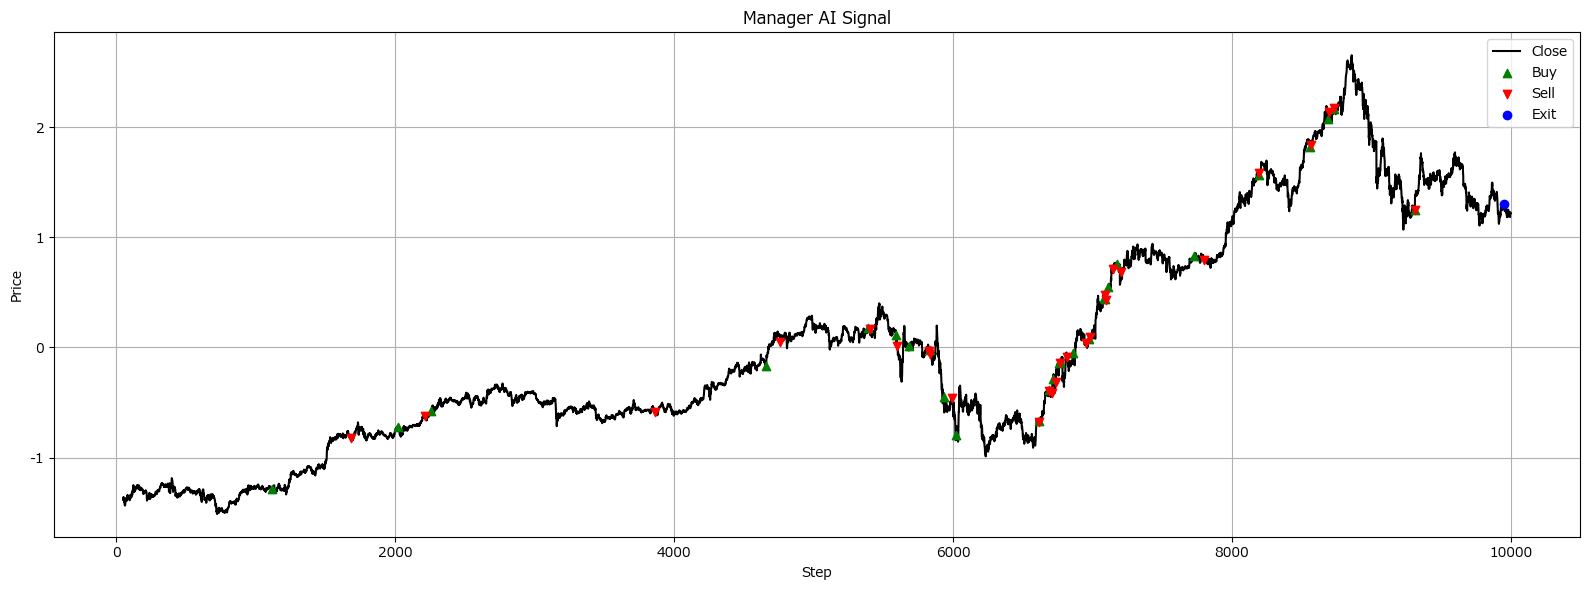

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
##################################################
# run_backtest() の出力を df にマージし、Buy / Sell / Exit シグナル付きのチャートを描画・保存します。
##################################################
# --- フォント設定（Windows対応：日本語表示）---
plt.rcParams["font.family"] = "Meiryo"
plt.rcParams['axes.unicode_minus'] = False  # マイナス記号が文字化けしないように設定

# --- signal列を初期化 ---
df["signal"] = ""  # 空文字で初期化
df["signal"] = df["signal"].astype(object)  # object型に明示変換（文字列 or シグナルを格納）

# 🧠 Manager AIのバックテストを実行し、シグナルを取得
signals = env.run_backtest(manager_model, max_steps=10000)

# --- signals（entry / exit）を df に反映 ---
for step, signal_type, pos in signals:
    if signal_type == "entry":
        df.loc[step, "signal"] = pos  # "long" or "short"
    elif signal_type == "exit":
        df.loc[step, "signal"] = "exit"

# =======================
# 📈 チャート描画処理
# =======================
plt.figure(figsize=(16, 6))
plt.plot(df["close"], label="Close", color="black")  # 終値ライン

# --- エントリー（Buy）シグナル ---
buy_signals = df[df["signal"] == "long"]
plt.scatter(buy_signals.index, buy_signals["close"], marker="^", color="green", label="Buy", zorder=5)

# --- エントリー（Sell）シグナル ---
sell_signals = df[df["signal"] == "short"]
plt.scatter(sell_signals.index, sell_signals["close"], marker="v", color="red", label="Sell", zorder=5)

# --- イグジット（Close）シグナル ---
exit_signals = df[df["signal"] == "exit"]
plt.scatter(exit_signals.index, exit_signals["close"], marker="o", color="blue", label="Exit", zorder=5)

# --- グラフの装飾 ---
plt.title("Manager AI Signal")     # タイトル
plt.xlabel("Step")                 # 横軸ラベル
plt.ylabel("Price")                # 縦軸ラベル
plt.grid(True)
plt.tight_layout()
plt.legend()

# --- グラフ保存（高解像度PNG）---
plt.savefig("manager_signals_chart.png", dpi=300, bbox_inches="tight")
plt.show()
